<a href="https://colab.research.google.com/github/Alvaro-Carrera/TUIA/blob/main/Proy_Final_Programaci%C3%B3n_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presentación

**Proyecto Final - Programación 1**

*Comisión 3 || Grupo 5*

**Integrantes:**

*   Carrera, Álvaro
*   Gay, Facundo
*   Mussi, Miguel






# Problemas

**Descripción del proyecto**

El presente proyecto propone analizar los datos correspondientes a los alojamientos ofrecidos por AirBnb en una ciudad a elección. Durante la realización del proyecto, los integrantes del grupo deben elegir qué preguntas desean responder y qué estructuras de datos emplearán para procesar la información. A su vez, deberán escribir el código que les permita llevar adelante el análisis y, finalmente, informar los resultados.


**Ciudad elegida y presentación de las preguntas** 

La ciudad elegida es Valencia (España). Esta ciudad cuenta con más de 6000 registros en la base de datos de Airbnb y una primera observación de los datos muestra que las plazas ofrecidas se distribuyen de forma asimétrica, nucleándose mayormente en 4 o 5 regiones. Otro aspecto distintivo es que se trata de una ciudad costera, lo que nos hace suponer que tal vez una fracción de la oferta presente un comportamiento estacional, es decir, que algunos de los parámetros como los precios involucrados o la disponibilidad y locación de oferta dependan fuertemente de la época del año. Este rápido y primer análisis de la ciudad nos motiva a plantear las siguientes ***preguntas***:



1.   ¿Cuál es el precio promedio en cada uno de los barrios de Valencia?
2.   ¿Cómo varían los precios de los alojamientos en función de la distancia al mar para las distintas épocas del año?
3.   ¿Dónde se ubica el centro geográfico de todas las ofertas de alojamiento de la ciudad y cómo fluctúa éste en las distintas estaciones del año?


# Estructura(s) de Dato(s)

Los datos de la base de datos de AirBnb relevantes para este proyecto se encuentran en 2 archivos disponibles en el sitio de descarga de la compañía: "listings.csv" y "calendar.csv". 

Parte de la información que se encuentra en el archivo "listings.csv" es almacenada en un diccionario que llamamos "id_barrio_lat_lon_tipo" y que presenta la siguiente estructura:

***id_barrio_lat_lon_tipo*** -> {id (int) : [barrio (int), latitud (float), longitud (float), tipo (string)]}.

El archivo "calendar.csv" contiene información sobre el precio y la disponibilidad de cada locación en cada día del año. Esa información es mantenida en nuestro programa en una lista de listas llamada "lista_calendar". Cada elemento de ***lista_calendar*** presenta la siguiente estructura:

[id (int), mes (int), precio (float), disponibilidad (string)]

Además de los datos provenientes de la base de datos de AirBnb se emplean las coordenadas de los puntos que definen la playa de la ciudad. Esa información se obtuvo empleando Google Maps y es almacenada en una lista de listas llamada ***coord_playa*** donde cada elemento de la lista presenta la siguiente estructura:

[longitud (float), latitud (float)]

# Carga de Datos

In [ ]:
# esto permite importar los archivos de entrada desde un drive para no tener que cargarlos en cada sesión
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
from math import sqrt,sin,acos,log
import matplotlib.pyplot as plt


# --- Funciones Auxiliares para ajustar el formato y tipo de datos ---
# convierte el mes de string a entero
def set_month(date):                        # recibe "yyyy-mm-dd" como argumento
    return int(date[5:7])                   # convierte a entero la dupla "mm"

# convierte el precio de string a flotante, sin signo $ ni separador de miles
def convert_price(precio):                  # recibe "$p,ppp.00" como argumento
    precio_temp = ""                        # inicializa una variable temporal
    for i in range(1, len(precio)):         # lee desde el índice 1 para quitar el signo $
        if precio[i] == ",":                # busca la/s coma decimal/es para quitar/las
            continue                        # encuentra una coma y la omite
        precio_temp += precio[i]            # actualiza la variable temporal sin coma

    return float(precio_temp)               # convierte a flotante el precio
# -- Fin Funciones Auxiliares


# --- Lectura del archivo Listings ---
# Cabeceras de columnas de archivo listings:
# id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,\
# room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,\
# calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
# Ejemplo: [48154,beautiful apartment wifi,219476,Toni,LA SAIDIA,\
# MORVEDRE,39.48375,-0.37502,Entire home/apt,66,3,120,2022-03-09,0.86,2,326,21,VT-41540-V]
def read_listings(file_listings):
    id_barrio_lat_lon_tipo = dict()                     # declara un nuevo diccionario
    # Genera diccionario = (id, [barrio, lat, lon, tipo])
    with open(file_listings, mode="r", encoding="utf8") as f_listing:
        reader = csv.reader(f_listing, delimiter=',', quotechar='"')
        for index, fila in enumerate(reader):
            if fila[0] == "id":                         # busca la primera fila (comienza con "id")
                continue                                # salta la primera fila

            id = int(fila[0])                           # genera clave entera (id) para diccionario
            barrio = fila[5]                            # registra barrio (índice 5) - cadena
            lat = float(fila[6])                        # registra latitud (índice 6) - flotante
            lon = float(fila[7])                        # registra longitud (índice 7) - flotante
            tipo = fila[8]                              # registra tipo (índice 8) - cadena

            id_barrio_lat_lon_tipo[id] = [barrio, lat, lon, tipo]   # agrega cada lista al diccionario
    return id_barrio_lat_lon_tipo

# --- Lectura del archivo Calendar ---
# Cabeceras de columnas de archivo calendar:
# listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
# Ejemplo: [48154,2022-03-21,f,$55.00,$55.00,3,25]
def read_calendar(file_calendar):
    lista_calendar = []                                     # declara nueva lista
    # Genera lista = [id, mm, pppp, t/f]
    with open(file_calendar, mode="r", encoding="utf8") as f_calendar:
        reader = csv.reader(f_calendar, delimiter=',', quotechar='"')
        for fila in reader:
            if fila[0] == "listing_id":                     # busca la primera fila (comienza con "listing_id")
                continue                                    # salta la primera fila
            cal_id = int(fila[0])                           # registra id entero para la lista
            mes = set_month(fila[1])-1                      # registra mes y ajusta el intervalo a 0-11
            precio = convert_price(fila[3])                 # registra precio sin $ ni comas
            disp = fila[2]                                  # registra disponibilidad "t" o "f"
            lista_calendar.append([cal_id, mes, precio, disp])      # agrega cada fila a la lista
    return lista_calendar

# --- Lectura del archivo puntos_playa ---
# importa las coordenadas de los puntos sobre la playa
# retorna: [[lon_1,lat_1],...,[lon_n,lat_n]]; en orden creciente de latitud
def read_playa(file_playa):
    data = []
    with open(file_playa, "r") as filename:
        reader = csv.reader(filename, delimiter=',')
        for lon,lat in reader:
            data.append((float(lon),float(lat)))
    data.sort(key = lambda x:x[1]) # ordenamos por latitud
    return data


# --- Lectura de archivos Listings, Calendar y Puntos_playa
in_path = "/content/drive/MyDrive/Valencia/Input/"
out_path = "/content/drive/MyDrive/Valencia/Output/"
file_l = "listings_2022_march.csv"
file_c = "calendar_2022_march.csv"
file_p = "puntos_playa.csv"

id_barrio_lat_lon_tipo = read_listings(in_path + file_l)
lista_calendar = read_calendar(in_path + file_c)
coord_playa = read_playa(in_path + file_p)

meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]


# Primera Pregunta


---



## Introducción

Las propiedades ofrecidas en la ciudad de Valencia se encuentran localizadas en distintos barrios de la ciudad. Una pregunta que surge naturalmente es cuál es el precio promedio en cada barrio. En nuestro caso, nos propusimos hallar ese precio promedio por barrio, para cada mes del año.

Decidimos excluir de nuestro análisis aquellos registros que figuraran como no disponibles ya que no tenemos forma de saber si esa ubicación ya fue reservada o no se ofrece por alguna otra razón en la fecha correspondiente.

Para haller el precio promedio se definieron dos diccionarios:

1. ***barrio_precios:*** diccionario que emplea como clave el nombre del barrio y como valor una lista de 12 elementos donde se acumulan los precios para ese barrio en cada mes del año
2. ***barrio_cant:*** diccionario que emplea como clave el nombre del barrio y como valor una lista de 12 elementos donde se acumula la cantidad de veces que se consideró un precio en un barrio y mes determinado.

Finalmente, se realiza el cociente entre los precios acumulados y las cantidades acumuladas, en cada barrio y para cada mes, para hallar el precio promedio por barrio en cada uno de los meses del año.



In [ ]:
# --- Problema 1 | INICIO ---

# --- registro de datos en diccionarios para precios por barrio
# IGUAL QUE LA SOLUCIÓN ANTERIOR PERO USANDO SOLO: barrios_precios y barrios_cant
barrio_precios = dict()										# declara un nuevo diccionario
barrio_cant = dict()										# declara un nuevo diccionario

for id_mes_precio in lista_calendar:						# compara id de lista [id, mm, pppp, disp]
  if id_mes_precio[3]=="f":								# busca los registros no disponibles (>>)
    continue											# (>>) omite los registros no disponibles
  id=id_mes_precio[0]
  mes = id_mes_precio[1]
  precio = id_mes_precio[2]
  if precio==0:                               # ignoramos los registros sin precio definido
    continue
  barrio = id_barrio_lat_lon_tipo[id][0]			# registra barrio
  if barrio not in barrio_precios:						# busca un barrio no registrado
    barrio_precios[barrio] = [0]*12               # inicializa lista precios [0,0,0,0,0,0,0,0,0,0,0,0]
    barrio_cant[barrio] = [0]*12                  # inicializa las cantidades [0,0,0,0,0,0,0,0,0,0,0,0]								

  barrio_precios[barrio][mes] += precio
  barrio_cant[barrio][mes] += 1

# --- cálculo de precios promedio por barrio
for barrio,cantidades in barrio_cant.items():
  for mes in range(12):
    if cantidades[mes] == 0:
      continue
    barrio_precios[barrio][mes] = round(barrio_precios[barrio][mes]/cantidades[mes],2)

## salida por pantalla
# for barrio,precios in barrio_precios.items():
  # print (barrio + ":",precios)

# salida a archivo csv
with open(out_path + "precio_por_barrio.csv","w",newline='') as f:
    writer = csv.writer(f)
    for barrio,precios in barrio_precios.items():
      fila = [barrio] + precios
      writer.writerow(fila)

# --- Problema 1 | FIN ---

## Representación Gráfica

El precio promedio por barrio para cada mes del año elegimos representarlo gráficamente a través de un mapa de calor. 

Cada uno de los barrios está representado por una fila del gráfico y las columnas representan a los meses del año. El color de la celda corrrespondiente se relaciona con el precio promedio de acuerdo al gradiente de colores mostrado en la paleta que se muestra a la derecha del gráfico.

Para evitar que la amplitud del rango de valores de precios dificultara apreciar variaciones más pequeñas se aplicó una escala logarítmica a los precios promedio.

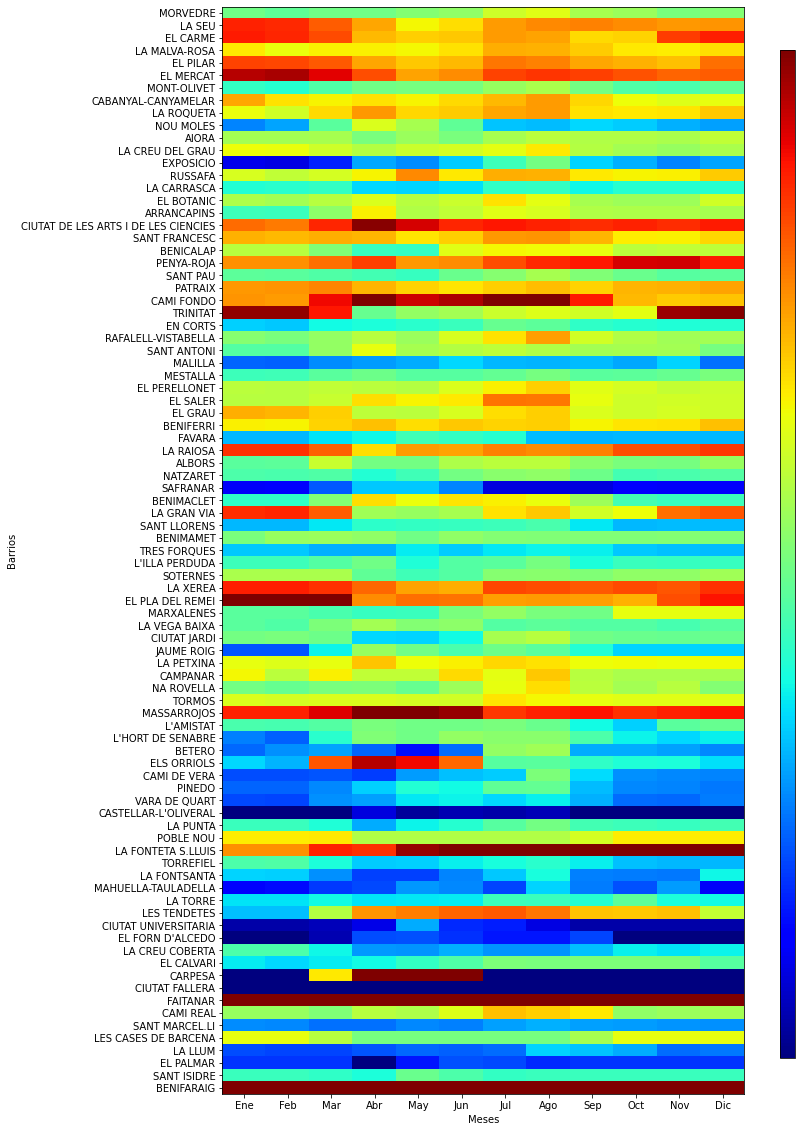

In [ ]:
# Código para graficar
valores=[]
for barrio,precios in barrio_precios.items():
  log_vals = []
  for i in range(12):
    if precios[i]==0: log_vals.append(0)
    else : log_vals.append(log(precios[i]))
  valores.append(log_vals)

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot()

im = ax.imshow(valores,aspect="auto",vmin=3.2,vmax=5.6,cmap = "jet")

ax.set_xlabel('Meses')
ax.set_ylabel('Barrios')

ax.set_xticks(range(len(meses)))
ax.set_yticks(range(len(barrio_precios)))

ax.set_xticklabels(meses)
ax.set_yticklabels(barrio_precios.keys())


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

# Segunda Pregunta


---



## Introducción

Cabe esperar que los precios promedio de los alojamientos reflejen una estacionalidad asociada al carácter turístico de la ciudad. Por otra parte, en caso de que la playa sea uno de los principales atractivos de la ciudad, podemos imaginar que tal vez la distancia al mar sea uno de los factores que repercuten en el precio de las locaciones. En esta pregunta se busca entonces analizar la dependencia de los precios de los alojamientos con la distancia al mar en las distintas épocas del año.

La respuesta a esta pregunta presenta varios desafíos:

1.   Establecer la ubicación de la playa:
    
    Esto se resolvió con ayuda de Google Maps. Se definieron 168 puntos ubicados sobre la costa y sus coordenadas de latitud y longitud se exportaron a un archivo de texto. La curva que define a la playa se obtiene por interpolación lineal entre cada par de puntos sucesivos.

2.   Hallar la distancia de cada locación a la playa:

    Los datos de las ubicaciones están informados en base a latitudes y longitudes, es decir, posiciones angulares. Para poder estimar distancias es necesario expresar las ubicaciones en unidades de posiciones espaciales (por ejemplo, km). Para ello se empleó una proyección de uso frecuente conocida como proyección de Mercator y se escribió el código correspondiente en base al empleado por [Google Maps](https://developers.google.com/maps/documentation/javascript/examples/map-coordinates
).

    Una vez expresadas las ubicaciones en coordenadas cartesianas, para cada una de las locaciones: (i) se halló la distancia a cada uno de los segmentos que definen la playa y (ii) se retuvo únicamente la mínima distancia.

3.   Hallar el precio de cada propiedad en las distintas épocas del año

4.   Informar el precio en cada época del año como una función de la distancia al mar



In [ ]:
# --- Problema 2 | INICIO ---

# producto escalar en 2D
# recibe dos puntos en el plano con el formato a=[x,y]
# retorna un número flotante
def dot(a,b):
    return a[0]*b[0]+a[1]*b[1]

# distancia entre un punto y un segmento
# recibe un punto p:[x,y] y un segmento seg:[[x1,y1],[x2,y2]]
# TODO: agregarle como retorno el correspondiente punto sobre el segmento?
# retorna float
def dist_to_seg(p,seg):
    a,b = seg[0],seg[1] # extremos del segmento
    ap = [p[0]-a[0],p[1]-a[1]] # vector desde "a" hasta "p"
    ab = [b[0]-a[0],b[1]-a[1]] # vector desde "a" hasta "v"
    u = dot(ap,ab)/ dot(ab,ab) # proyección de ap sobre ab
    if u<0: # el punto "a" del segmento es el más cercano a "p"
      return sqrt(dot(ap,ap))
    if u>1: # el punto "b" del segmento es el más cercano a "p"
        ret = [b[0]-p[0],b[1]-p[1]]
        return sqrt(dot(ret,ret))
    ac = [ab[0]*u,ab[1]*u] # el vector ac apunta al punto más cercano a "p"
    ret = [ap[0] - ac[0] , ap[1]-ac[1]]
    return sqrt(dot(ret,ret))

# convierte posiciones globales (lon,lat) en puntos en el plano xy usando la proyección de Mercator;
# https://developers.google.com/maps/documentation/javascript/examples/map-coordinates
# recibe 2 números flotantes: lon,lat
# retorna 2 números flotantes: x,y
def convert_to_xy(lon,lat):
    PI = acos(-1)
    siny = sin(lat * PI / 180)
    x = 0.5 + lon / 360
    y = 0.5 - log((1 + siny) / (1 - siny)) / (4 * PI)
    return x,y

# función para calcular la menor distancia de un punto del plano xy a algún punto sobre costa
# recibe las coordenadas x,y del punto y la lista con los puntos que definen la costa
# retorna un número flotante
def dist_to_costa(x,y,costa_xy):
    dist=1E18                                   # inicializamos una distancia muy grande
    p = [x,y]                                   # ubicación de la locación a la cual le calcularemos su distancia a la costa
    for i in range(1,len(costa_xy)):            # para cada segmento de la costa calculamos la distancia entre p y el segmento
        seg = [costa_xy[i-1],costa_xy[i]]       # segmento de la costa
        dist = min(dist,dist_to_seg(p,seg))     # calculamos la distancia entre p y seg y actualizamos la menor distancia hallada hasta ahora
    return dist

# función para calcular precio mensual promedio para cada id
# recibe la lista list_calendar que contiene información sobre precio y disponibilidad de cada locación en cada día del año
# retorna un diccionario del tipo: {id:[precio_enero,...,precio_diciembre]}
def get_precio_mensual_id(lista_calendar):
    precio_mensual_id = dict()                   # se define el diccionario donde se guardarán los precios en cada mes, para cada id#
    cnt_id = dict()                              # se define el diccionario donde se guardará la cantidad de veces que se registró un precio, para cada mes y para cada id
    for id_mes_precio in lista_calendar:
        if id_mes_precio[3]=="f":                # si la locación no está disponible, no contemplaremos este registro
          continue
        id = id_mes_precio[0]
        mes = id_mes_precio[1]
        precio = id_mes_precio[2]
        if precio==0:                           # si no tuviera precio definido, omitimos este registro
          continue
        if id not in precio_mensual_id:         # se es la primera vez que aparece este id, creamos un nuevo registro en ambos diccionarios
          precio_mensual_id[id] = [0]*12        # nuevo registro en el diccionario, con clave id y precios inicializados en 0 para todos los meses
          cnt_id[id] = [0]*12                   # nuevo registro en el diccionario, con clave id y cantidades inicializadas en 0 para todos los meses
        precio_mensual_id[id][mes] += precio    # sumamos el precio actual en el id y mes correspondiente
        cnt_id[id][mes] += 1                    # incrementamos el contador de precios para el id y mes correspondiente
    
    # dividimos la suma de precios por las cantidades para obtener el promedio
    for id,cnt in cnt_id.items():
      for mes in range(12):
        if cnt[mes]>0:                          # solo si existe al menos un precio definido para este id, en este mes, realizamos la división
          precio_mensual_id[id][mes] /= cnt[mes]
    return precio_mensual_id

# función para obtener la lista de precios en función de la distancia al mar, para mes del año
# retorna una lista de listas: [[tipo_1,distancia_1,precio_1_enero,...,precio_1_diciembre],...,[tipo_n,distancia_n,precio_n_enero,...,precio_n_diciembre]]
def get_precio_dist(listings,lista_calendar,coord_playa):
    costa_xy=[]                                             # esta lista contendrá las coordenadas x,y de los puntos sobre la playa
    # se completa la lista costa_xy convirtiendo los datos de long y lat de los puntos sobre la playa
    for punto in coord_playa:
        costa_xy.append(convert_to_xy(punto[0],punto[1]))

    # las coordenadas en el plano toman valores entre 0 y 1; es necesario aplicarles un factor de escala para pasarlas a km reales
    # usando google maps se hallo la distancia entre el primero y último de los puntos de la playa (63.2 km)
    extremos_costa = [costa_xy[0][0]-costa_xy[-1][0],costa_xy[0][1]-costa_xy[-1][1]]  # segmento desde el punto más al sur hasta el punto más al norte de la costa
    scale = 63.2 / sqrt(dot(extremos_costa,extremos_costa))                           # factor de escala para pasar a km

    distancias=dict()                                                   # diccionario que guarda la distancia a la playa de cada locación
    for id,data in listings.items():                                    # recorremos todas las locaciones
        x,y = convert_to_xy(data[2],data[1])                            # ubicación en el plano xy de la locación actual
        distancias[id] = [data[3],dist_to_costa(x,y,costa_xy) * scale]  # registramos la distancia (en km) de la locación actual a la playa

    precio_mensual_id = get_precio_mensual_id(lista_calendar)           # obtenemos el precio promedio para cada locación y para cada mes
    precio_dist = []                                                    # lista donde cada elemento es: [tipo,distancia,precio_enero,...,precio_diciembre]

    for id,precios in precio_mensual_id.items():
        if id not in distancias:                                        # si este id no se encuentra en el diccionario de distancias
          continue
        precio_dist.append(distancias[id] + precios)

    precio_dist.sort() # la lista se devuelve ordenada por tipo de alojamiento en primer lugar y por distancia a la playa en segundo lugar
    return precio_dist

# precio_dist = [tipo,dist,precio_enero,...,precio_dic]
precio_dist = get_precio_dist(id_barrio_lat_lon_tipo,lista_calendar,coord_playa)
with open(out_path + "precio_dist.csv","w",newline='') as f:
    writer = csv.writer(f)
    writer.writerows(precio_dist)

# --- Problema 2 | FIN ---

## Representación gráfica

Para representar gráficamente los precios en función de la distancia al mar se definió, previamente, un numero ***num_bins=12*** de rangos de distancias y para cada uno de esos rangos se obtuvo el precio promedio para cada mes del año.

En el gráfico incluido aquí se muestran únicamente los precios promedio de los meses de verano (enero y febrero) e invierno (julio y agosto) para simplificar la visualización.


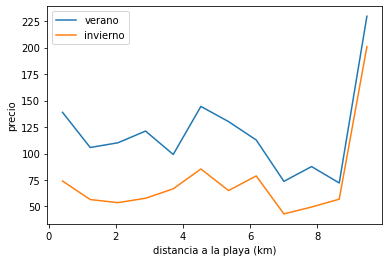

In [ ]:
# Código para graficar la segunda pregunta

fig, ax = plt.subplots()

num_bins = 12
min_dist=10000
mx_dist = 0
for i in range(len(precio_dist)):
  min_dist=min(min_dist,precio_dist[i][1])
  mx_dist =max(mx_dist,precio_dist[i][1])
ancho_bin = (mx_dist-min_dist + 0.00001)/num_bins
x = []
for i in range(num_bins):
  x.append(min_dist + (i + 0.5) * ancho_bin)

yverano = [0]*num_bins
cntverano = [0]*num_bins
yinvierno = [0]*num_bins
cntinvierno = [0]*num_bins

tipos = ["Entire home/apt","Shared room","Private room","Hotel room"]
#vertipo=1

for i in range(len(precio_dist)):
#  if precio_dist[i][0]!=tipos[3]: 
#    continue
  x_bin = int((precio_dist[i][1]-min_dist) / ancho_bin)
  if precio_dist[i][3]+precio_dist[i][4]==0 or precio_dist[i][8]+precio_dist[i][9]==0: continue 
  for mes in range(1,3):
      yinvierno[x_bin] += precio_dist[i][mes+2]
      cntinvierno[x_bin] += 1
  for mes in range(6,8):
    if precio_dist[i][mes+2]>0:
      yverano[x_bin] += precio_dist[i][mes+2]
      cntverano[x_bin] += 1
for i in range(num_bins):
  if cntverano[i]>0:
    yverano[i] /= cntverano[i]
  if cntinvierno[i]>0:
    yinvierno[i] /= cntinvierno[i]

ax.plot(x, yverano,x,yinvierno)
ax.set_xlabel('distancia a la playa (km)')
ax.set_ylabel('precio')
plt.legend(["verano","invierno"])
plt.show()

# Tercera Pregunta


---



## Introducción

Como se datalló con anterioridad, durante la resolución de esta actividad se analizaron más de 6000 registros de alojamientos distribuidos de manera particular en la superficie de Valencia. 

Esta distribución presenta algunas regiones en donde la densidad de puntos es significativamente superior al resto. 
Además, como se analizó en los problemas anteriores, la oferta de locaciones también tiene una variación estacional.

En función a todo ello, se pretende localizar el centro geográfico de todas las ofertas disponibles de la ciudad de Valencia y analizar si éste presenta una variación estacional.


La resolución de las dos partes de esta pregunta se realiza en una misma línea de acción. 


1.   Definir un par de listas en las que se irán acumulando las latitudes y longitudes por meses conforme vayan apareciendo en la lectura del archivo "calendar" y una lista adicional a modo de contador, también por meses. 
2.   Calcular la latitud y longitud promedio en cada mes, dividiendo cada elemento de las listas anteriores por el valor acumulado en el contador correspondiente.





In [ ]:
# --- Problema 3 | INICIO ---

# --- registro de datos para posición promedio
lat_prom = [0]*12                                       # inicializa lista latitud [0,0,0,0,0,0,0,0,0,0,0,0]
lon_prom = [0]*12                                       # inicializa lista longitud [0,0,0,0,0,0,0,0,0,0,0,0]
mes_cant = [0]*12                                       # inicializa lista cantidad [0,0,0,0,0,0,0,0,0,0,0,0]
for id_mes in lista_calendar:                           # compara id de lista [id, mm, pppp, disp] con el diccionario
    if id_mes[3]=="f":                                  # busca los registros no disponibles (>>)
        continue                                        # (>>) omite los registros no disponibles
    id_datos = id_barrio_lat_lon_tipo[id_mes[0]]        # registra en id_datos = [barrio, lat, lon, tipo]
    lat_prom[id_mes[1]] += id_datos[1]                  # acumula latitud en el índice corresp. al mes
    lon_prom[id_mes[1]] += id_datos[2]                  # acumula longitud en el índice corresp. al mes
    mes_cant[id_mes[1]] += 1                            # incrementa contador en el índice corresp. al mes


# --- cálculo de posición promedio
for i in range(12):                                     # intervalo de 0 a 11
    if mes_cant[i] == 0:                                # si no hay registros en algún mes (>>)
        continue                                        # (>>) evita dividir por 0
    lat_prom[i] = lat_prom[i]/mes_cant[i]               # calcula latitud promedio en cada índice
    lon_prom[i] = lon_prom[i]/mes_cant[i]               # calcula longitud promedio en cada índice

# --- Salidas por pantalla (Problema 3)
#print("Latitud Promedio: ", lat_prom)                   # Muestra por pantalla lat. prom.
#print("Longitud Promedio: ", lon_prom)                  # Muestra por pantalla long. prom.
#print("Cantidad de Registros: ", mes_cant)              # Muestra por pantalla cant. de registros mensuales
#print("Cantidad total de registros: ", sum(mes_cant))   # la función "sum" suma los elementos de la lista

# --- Salidas por archivos csv (Problema 3)
file_cg = "centro_geo.csv"

csvData = [["Meses"] + meses, ["Latitud"] + lat_prom, ["Longitud"] + lon_prom, ["Cantidad"] + mes_cant]         # Lista completa de filas para el csv

csvFile = open(out_path+file_cg, 'w')
with csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

print("Archivo completo")

# --- Problema 3 | FIN ---

Archivo completo


## Representación Gráfica

Para la realización del gráfico correspondiente a este problema definimos que el tipo más adecuado era el denominado "scatter". De esta manera podemos representar la distribución bidimensional de los doce puntos correspondientes a las longitudes (abcisas) y latitudes (ordenadas) promedio de cada mes. 

Se rotularon los ejes, configuraron los colores y adecuaron las escalas de ambos para una mejor visualización. También fue necesario hacer un pequeño ajuste en las etiquetas de los puntos para que no se superpusieran los más próximos.

Paralelamente, para poder realizar un análisis independiente en cada magnitud, se representaron las variaciones mensuales de las latitudes y longitudes en gráficos de barra individuales, a los que se les aplicaron ajustes similares de leyendas, colores y escalas.

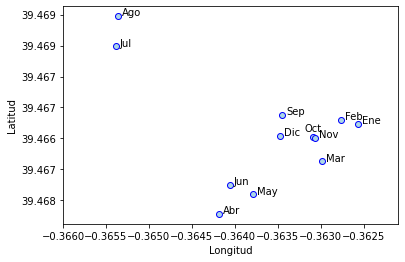

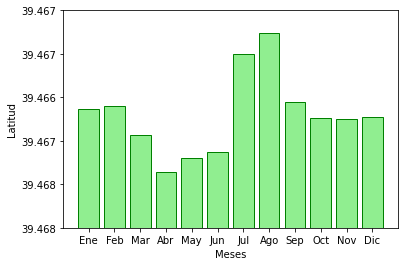

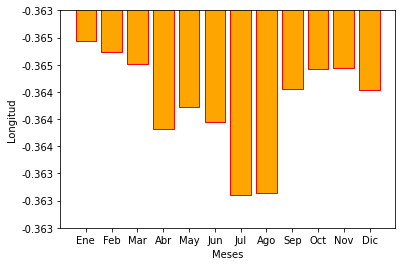

In [ ]:
from matplotlib import colorbar
# --- Gráfico 3 | INICIO ---
fig, ax = plt.subplots()
ax.scatter(lon_prom,lat_prom, color='lightblue', edgecolor='blue')

for i in range(12):
  if i!=9:
    ax.text(x=lon_prom[i]+.00005,y=lat_prom[i]+.00001,s=meses[i])
  else:
    ax.text(x=lon_prom[i]-.0001,y=lat_prom[i]+.0001,s=meses[i])

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim(-0.366,-0.3621)
plt.gca().set_yticklabels(['{:,.3f}'.format(x) for x in lat_prom])

plt.show()

fig2, ax2 = plt.subplots()
ax2.bar(meses,lat_prom, color='lightgreen', edgecolor='green')

ax2.set_ylim(bottom=39.465,top=39.47)
ax2.set_xlabel('Meses')
ax2.set_ylabel('Latitud')
plt.gca().set_yticklabels(['{:,.3f}'.format(x) for x in lat_prom])
plt.show()

fig3, ax3 = plt.subplots()
ax3.bar(meses,lon_prom, color='orange', edgecolor='red')

ax3.set_ylim(bottom=-0.366,top=-0.362)
ax3.set_xlabel('Meses')
ax3.set_ylabel('Longitud')
plt.gca().set_yticklabels(['{:,.3f}'.format(x) for x in lon_prom])
plt.show()

# --- Gráfico 3 | FIN ---